## Dependecies
here we import the required dependencies and set some useful parameters.

convmixerlib it's a simple custom module where i've organized all the code required for running this notebook. i encourage to have a look at the *models.py* and *blocks.py* file under the folder *convmixerlib*, where you will find respectively the model architecture and the basic building block of a convmixer network.

In [7]:
# dependecies
import keras
import tensorflow as tf
import convmixerlib as cm

In [8]:
# some parameters
NUM_CLASSES = 10
BATCH_SIZE = 64
SEED = 1993

## Load and split data
load cifar-10 data and split in training, validation and test sets.

In [9]:
# load cifar10 data
(images_train, labels_train), (images_test, labels_test) = keras.datasets.cifar10.load_data()

# convert images data to float
images_train = tf.cast(images_train, dtype=tf.float32)
images_test = tf.cast(images_test, dtype=tf.float32)

# convert labels to one hot encoding
labels_train = tf.one_hot(labels_train, depth=NUM_CLASSES, dtype=tf.float32)
labels_train = tf.reshape(labels_train, shape=(labels_train.shape[0], NUM_CLASSES))

# split data in training and validation sets
(images_train, labels_train), (images_val, labels_val) = cm.processing.train_val_split(images_train, labels_train, val_perc=0.1)

## Tensorflow data pipelines
tensorflow data pipelines are easy and very useful for defining sequences of operations that needs to be applied to our data before being feeded as input to a model.

below there is a pipeline defined for each splits of cifar-10 data loaded previously, applying the following operations:
- shuffle
- batch
- randomly augment data

note that the data augmentation procedure i wrote it's different and simpler to what the authors used in the paper, for this reason i expect different results on cifar-10 data, probably worse than the paper ones.

In [10]:
# data pipelines
ds_train = (
    tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    .shuffle(buffer_size=len(labels_train))
    .batch(batch_size=BATCH_SIZE)
    .map(cm.processing.data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    .shuffle(buffer_size=len(labels_val))
    .batch(batch_size=BATCH_SIZE)
    .map(cm.processing.data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices(images_test)
    .batch(batch_size=BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## ConvMixer classifier
build a convmixer classifier, using some of the proposed hyperparameters by the paper on cifar-10 data.

with this setup the network has only around 0.6M of trainable parameters!

looking at the paper i found strange the complete absence of dropouts layers, which have been proven to work effectively against over-fitting and stabilize the training procedure. of course there are other regularization techniques and the authors looks like to have heavily relied on data augmentation procedure to avoid any over-fitting.

anyway i decided to optionally include some dropouts layer in my convmixer implementation and we'll do a comparison later on.. spoiler, the model with dropouts layer will generalize better than the one without. as said before the data augmentation function i'm using it's a lot simpler that what the author proposed in their paper, so i'm not particularly surprised by this result.

In [11]:
# build convmixer model with dropouts layers
model = cm.models.build_convmixer_classifier(
    input_shape=(32, 32, 3),
    patches_embedding_dimension=256,
    depth=8,
    patch_size=2,
    kernel_size=5,
    num_classes=NUM_CLASSES,
    rescale_inputs=True,
    dropout_rate=0.15
)

# build convmixer model without dropouts layers
model_without_dropout = cm.models.build_convmixer_classifier(
    input_shape=(32, 32, 3),
    patches_embedding_dimension=256,
    depth=8,
    patch_size=2,
    kernel_size=5,
    num_classes=NUM_CLASSES,
    rescale_inputs=True,
    dropout_rate=None
)

# model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_135CL… │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches (Conv2D)    │ (None, 16, 16,    │      3,328 │ keras_tensor_135… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches-gelu        │ (None, 16, 16,    │          0 │ patches[1][0]     │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches-batchnorm   │ (None, 16, 16,    │      1,024 │ patches-gelu[1][… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-d… │ (None, 16, 16,    │          0 │ patches-batchnor… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-d… │ (None, 16, 16,    │      6,656 │ convmixer-block0… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-d… │ (None, 16, 16,    │          0 │ convmixer-block0… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-d… │ (None, 16, 16,    │      1,024 │ convmixer-block0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-a… │ (None, 16, 16,    │          0 │ convmixer-block0… │
│ (Add)               │ 256)              │            │ convmixer-block0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-p… │ (None, 16, 16,    │     65,792 │ convmixer-block0… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-p… │ (None, 16, 16,    │          0 │ convmixer-block0… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block0-p… │ (None, 16, 16,    │      1,024 │ convmixer-block0… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block1-d… │ (None, 16, 16,    │          0 │ convmixer-block0… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block1-d… │ (None, 16, 16,    │      6,656 │ convmixer-block1… │
│ (DepthwiseConv2D)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block1-d… │ (None, 16, 16,    │          0 │ convmixer-block1… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block1-d… │ (None, 16, 16,    │      1,024 │ convmixer-block1… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convmixer-block1-a… │ (None, 16, 16,    │          0 │ convmixer-block1

 Total params: 602,890 (2.30 MB)

 Trainable params: 594,186 (2.27 MB)

 Non-trainable params: 8,704 (34.00 KB)

## Optimizer, loss, metrics
as proposed by the paper we setup as optimizer adam weighted with weight decay set to zero.

we can use categorical cross entropy as loss, since we have 10 classes in cifar-10 data.

we simply use accuracy as monitor of metrics during the training procedure.

In [13]:
# compile model with dropouts layers
model.compile(
    optimizer=keras.optimizers.AdamW(weight_decay=0),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

# compile model without dropouts layers
model_without_dropout.compile(
    optimizer=keras.optimizers.AdamW(weight_decay=0),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

## Model training

training the models with and without dropouts layers.

we use an early-stopping approach for stopping the training procedure when there is no more noticeable improvements on the validation set.

In [14]:
# fit the model with dropouts layers using validation set to estimate model performances on test data
# set verbose=1 for showing training progress, i've disabled it to avoid long scrolling through the notebook
history = model.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=5,
            verbose=0,
            restore_best_weights=True,
            start_from_epoch=5,
        )
    ]
)

I0000 00:00:1723542892.135946   32637 service.cc:146] XLA service 0x7f46bc00c350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723542892.135993   32637 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 3500 Ada Generation Laptop GPU, Compute Capability 8.9
2024-08-13 11:54:52.293510: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-13 11:54:52.952314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-13 11:54:57.102200: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[64,256,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,256,16,16]{3,2,1,0}, f32[256,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=256, custom_call_target="__cudnn$convForward", backend_config={"opera

In [15]:
# fit the model without dropouts layers using validation set to estimate model performances on test data
# set verbose=1 for showing training progress, i've disabled it to avoid long scrolling through the notebook
history_without_dropout = model_without_dropout.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=5,
            verbose=0,
            restore_best_weights=True,
            start_from_epoch=5,
        )
    ]    
)

## Loss curves
let's compare the training and validation loss curves between the two models.

it's pretty obvious that the model with dropouts layers shows better looking loss curves and achieve better generalization on future data, while the moedl without dropouts layers quickly goes into overfitting.

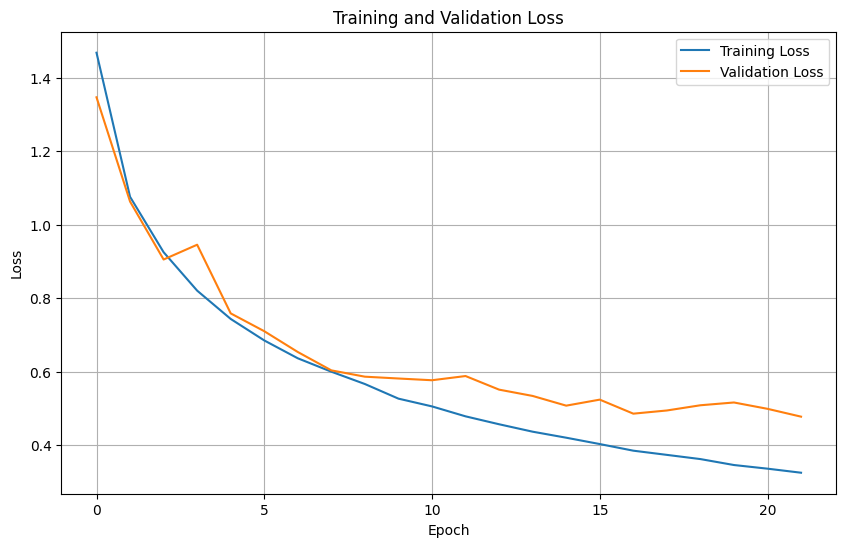

In [16]:
# model wit dropouts layers
cm.plots.plot_training_history(history.history, figsize=(10, 6), show=True)

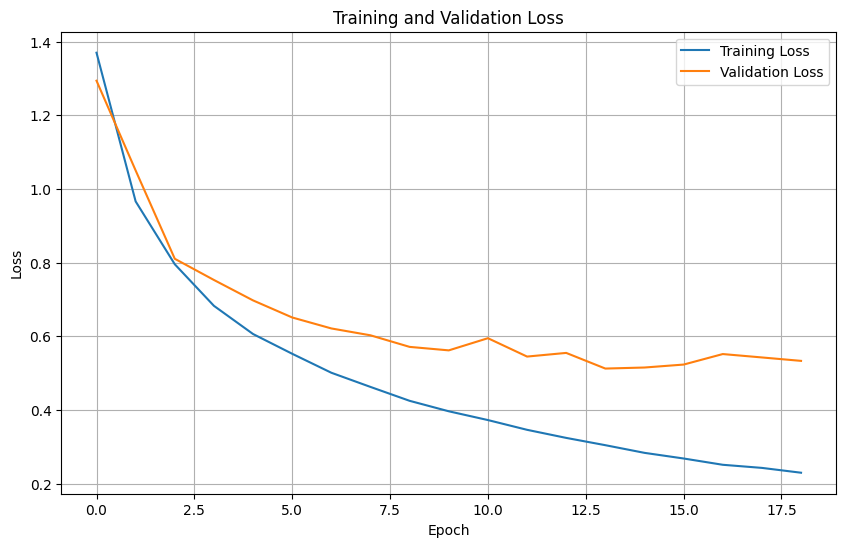

In [17]:
# model without dropouts layers
cm.plots.plot_training_history(history_without_dropout.history, figsize=(10, 6), show=True)

## Predictions
get predictions for the test set

In [19]:
# predictions on test data
predictions = []
for batch_test in ds_test:
    predictions.append(model.predict_on_batch(batch_test))
predictions = tf.concat(predictions, axis=0)
predictions = tf.math.argmax(predictions, axis=-1)
predictions = tf.cast(predictions, dtype=tf.uint8)
predictions = tf.expand_dims(predictions, axis=1)

2024-08-13 12:12:04.912971: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Quick evaluation on test data

from the validation set we expect to have around 80% accuracy and we are close

In [20]:
# accuracy on test data
accuracy = tf.cast(labels_test == predictions, dtype=tf.uint8)
accuracy = accuracy.numpy().sum() / len(accuracy)
print(f'test_categorical_accuracy: {accuracy:.4f}')

test_categorical_accuracy: 0.8320


# Conclusions

i'm pretty sure that with a better data augmentation process and a bit of optimizer tuning, we might get even better results, but that wasn’t my main goal

that said, getting 83% accuracy on cifar-10 with just 0.6M parameters and a really simple architecture you can code in a few lines is still pretty impressive!

i also think it's always interesting to build these architectures from scratch: you really get a feel for the authors' ideas and design choices when you're putting each layer together by yourself!